Se extraen los datos del archivo y se muestran los datos involucrados

In [22]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

# el archivo
archivo = "Flujo2019.mat"
datos = scipy.io.loadmat(archivo)

# los datos
datos.keys()

dict_keys(['__header__', '__version__', '__globals__', 'None', 'FlujoAgosto', 'FlujoDiciembre', 'FlujoJulio', 'FlujoJunio', 'FlujoNoviembre', 'FlujoOctubre', 'FlujoSeptiembre', '__function_workspace__'])

 FlujoJulio es un arreglo que representa los valores de consumo de agua durante julio de 2020. 
 
 Para utilizar estos datos en la red neuronal necesitamos normalizar, es decir, un valor entre entre $[0,1)$, ésto para ver de una mejor manera el comportamiento del flujo.

In [23]:

flujo = datos.get("FlujoJulio")
flujo


array([[5.0625, 5.065 , 5.065 , ..., 1.4525, 1.9   , 2.755 ]])

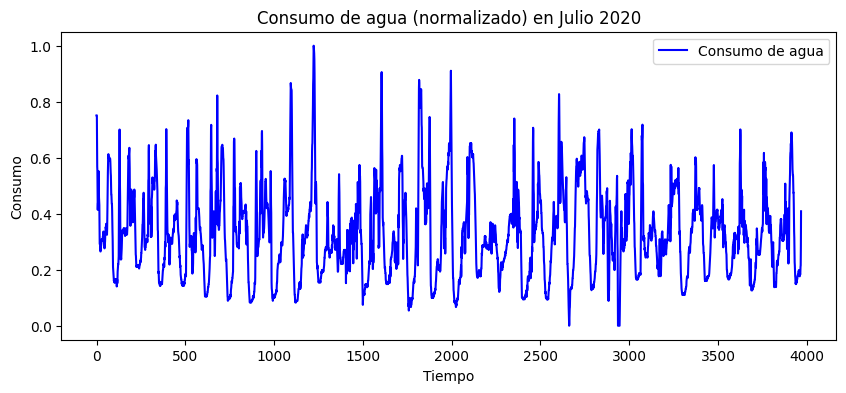

In [24]:
# el arreglo a una sola dimensión
flujo = flujo.flatten()

# normalizar cada uno de los datos 
min = np.min(flujo)
max = np.max(flujo)
flujo_norm = (flujo - min) / (max - min)

# representación de los datos ya normalizados
plt.figure(figsize=(10, 4))
plt.plot(flujo_norm, label="Consumo de agua", color='b')
plt.xlabel("Tiempo")
plt.ylabel("Consumo")
plt.title("Consumo de agua (normalizado) en Julio 2020")
plt.legend()
plt.show()


Entrenamiento: $3174$ muestras, corresponde al $80\%$ de los datos

Prueba: $793$ muestras, corresponde al $20\%$ de los datos

In [25]:
# dvidir los datos 
equipo = int(0.8 * len(flujo_norm))
x_entrena = flujo_norm[:equipo]
x_prueba = flujo_norm[equipo:]

y_entrena = np.roll(x_entrena, -1)[:-1]  
y_prueba = np.roll(x_prueba, -1)[:-1]

x_entrena.shape, y_entrena.shape, x_prueba.shape, y_prueba.shape


((3175,), (3174,), (794,), (793,))

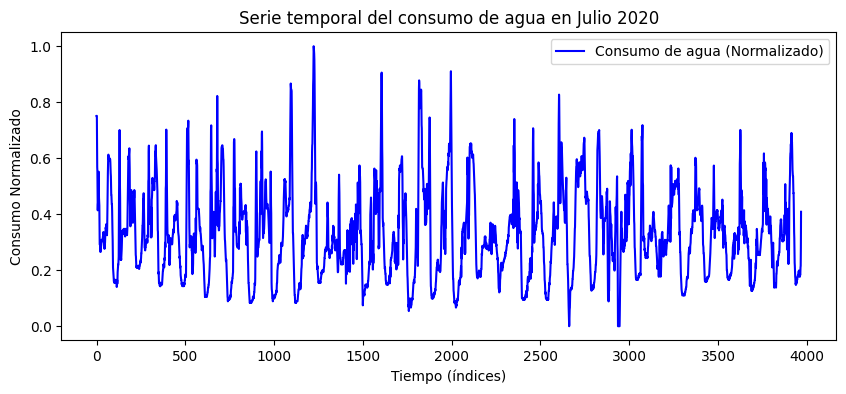

Época 0, Error: 0.4075607653625327
Época 100, Error: 0.014423411992765884
Época 200, Error: 0.00788289194192646
Época 300, Error: 0.007718671698819155
Época 400, Error: 0.007669719316701361
Época 500, Error: 0.007623001424558195
Época 600, Error: 0.007576451835827764
Época 700, Error: 0.007530031780997782
Época 800, Error: 0.0074837397546172685
Época 900, Error: 0.007437575007294633


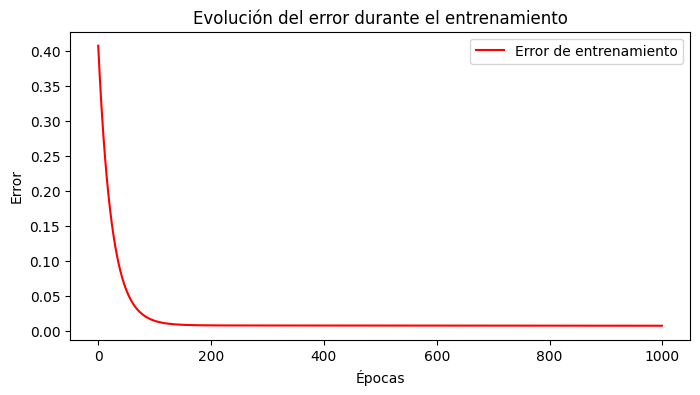

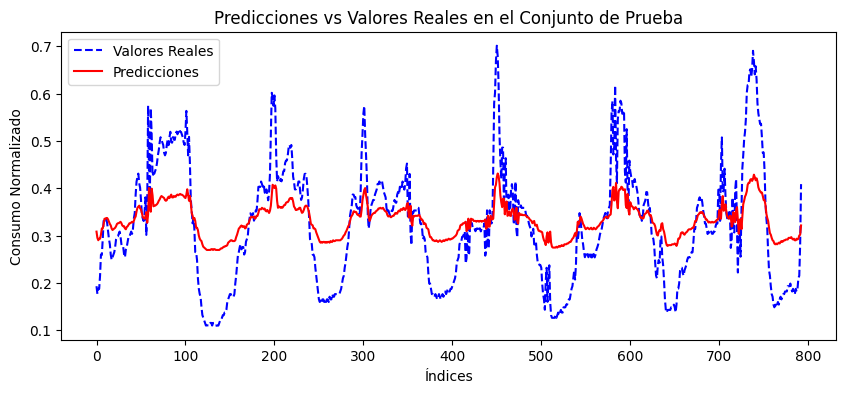

In [27]:

import scipy.io
import numpy as np
import matplotlib.pyplot as plt

# Cargar el archivo .mat
mat_file_path = "Flujo2019.mat"
data = scipy.io.loadmat(mat_file_path)

# Extraer datos de julio (Consumo de agua)
flujo_julio = data.get("FlujoJulio").flatten()

# Normalización Min-Max (0 a 1)
min_val = np.min(flujo_julio)
max_val = np.max(flujo_julio)
flujo_julio_norm = (flujo_julio - min_val) / (max_val - min_val)

# División de datos: 80% entrenamiento, 20% prueba
train_size = int(0.8 * len(flujo_julio_norm))
x_train = flujo_julio_norm[:train_size]
x_test = flujo_julio_norm[train_size:]

# Crear etiquetas (y) desplazando los datos en serie temporal
y_train = np.roll(x_train, -1)[:-1]  # Predecir el siguiente valor
y_test = np.roll(x_test, -1)[:-1]

# Ajustar dimensiones
x_train = x_train[:-1]

# Graficar datos normalizados
plt.figure(figsize=(10, 4))
plt.plot(flujo_julio_norm, label="Consumo de agua (Normalizado)", color='b')
plt.xlabel("Tiempo (índices)")
plt.ylabel("Consumo Normalizado")
plt.title("Serie temporal del consumo de agua en Julio 2020")
plt.legend()
plt.show()


# Definir la red neuronal simple con una capa oculta (2 neuronas) y función sigmoide
class OptimizedNeuralNetwork:
    def __init__(self, alpha=0.01, epochs=1000):
        self.alpha = alpha  # Tasa de aprendizaje
        self.epochs = epochs
        self.w1, self.w2, self.w3, self.w4 = np.random.randn(4)  # Pesos
        self.b2, self.b4, self.by = np.random.randn(3)  # Sesgos

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, z):
        s = self.sigmoid(z)
        return s * (1 - s)

    def train(self, x, y):
        errors = []
        for epoch in range(self.epochs):
            total_error = 0
            
            # Forward pass
            z2 = self.w2 * x + self.b2
            h1 = self.sigmoid(z2)
            
            z4 = self.w4 * x + self.b4
            h2 = self.sigmoid(z4)
            
            y_pred = self.w1 * h1 + self.w3 * h2 + self.by
            
            # Error
            error = 0.5 * (y_pred - y) ** 2
            total_error = np.mean(error)

            # Backpropagation (vectorizada)
            dE_dy = y_pred - y
            dE_dw1 = dE_dy * h1
            dE_dw3 = dE_dy * h2
            dE_dby = dE_dy

            dE_dh1 = dE_dy * self.w1
            dE_dh2 = dE_dy * self.w3

            dE_dw2 = dE_dh1 * self.sigmoid_derivative(z2) * x
            dE_db2 = dE_dh1 * self.sigmoid_derivative(z2)

            dE_dw4 = dE_dh2 * self.sigmoid_derivative(z4) * x
            dE_db4 = dE_dh2 * self.sigmoid_derivative(z4)

            # Actualización de parámetros
            self.w1 -= self.alpha * np.mean(dE_dw1)
            self.w3 -= self.alpha * np.mean(dE_dw3)
            self.by -= self.alpha * np.mean(dE_dby)

            self.w2 -= self.alpha * np.mean(dE_dw2)
            self.b2 -= self.alpha * np.mean(dE_db2)

            self.w4 -= self.alpha * np.mean(dE_dw4)
            self.b4 -= self.alpha * np.mean(dE_db4)

            errors.append(total_error)
            
            # Mostrar progreso
            if epoch % 100 == 0:
                print(f"Época {epoch}, Error: {total_error}")

        return errors

    def predict(self, x):
        h1 = self.sigmoid(self.w2 * x + self.b2)
        h2 = self.sigmoid(self.w4 * x + self.b4)
        return self.w1 * h1 + self.w3 * h2 + self.by


# Crear y entrenar la red neuronal optimizada
nn_opt = OptimizedNeuralNetwork(alpha=0.01, epochs=1000)
error_history_opt = nn_opt.train(x_train, y_train)

# Graficar la evolución del error
plt.figure(figsize=(8, 4))
plt.plot(error_history_opt, label="Error de entrenamiento", color='r')
plt.xlabel("Épocas")
plt.ylabel("Error")
plt.title("Evolución del error durante el entrenamiento")
plt.legend()
plt.show()

# Evaluar la red neuronal en datos de prueba
y_pred_test = nn_opt.predict(x_test[:-1])  # Ajustar longitud para comparación

# Graficar predicciones vs valores reales
plt.figure(figsize=(10, 4))
plt.plot(y_test, label="Valores Reales", color='b', linestyle="dashed")
plt.plot(y_pred_test, label="Predicciones", color='r')
plt.xlabel("Índices")
plt.ylabel("Consumo Normalizado")
plt.title("Predicciones vs Valores Reales en el Conjunto de Prueba")
plt.legend()
plt.show()

